In [1]:
import os 
import numpy as np 
from google.protobuf import text_format, json_format
import re
import json 
import sys 
import tqdm 

# add ./scripts path to sys path
sys.path.append("..") 
from src.utils import getMeshDimensions, getMeshCenter
import trimesh 

In [2]:
# collect all object ids 
google_scans_path = "/media/junting/SSD_data/google_object_dataset"
object_ids = os.listdir(google_scans_path)
exclude_ids = ['glb', 'google_scanned_objects.proto']
object_ids = [object_id for object_id in object_ids if object_id not in exclude_ids]

# output path
output_path = "../../data/google_scanned_object/"

## Util functions 

In [4]:
def parse_metadata(file):
    # Create a proto object and serialize it to a text proto string.
    metadata_proto = google_scanned_objects_pb2.Metadata()
    # Parse a text proto into dictionary.
    with open(file, 'r') as f:
        message = text_format.Merge(f.read(), metadata_proto)
        meta_dict = json_format.MessageToDict(message)
    return meta_dict

In [3]:
def collect_thumbnails(objects_dir, target_dir, object_ids):
    """
    Collect thumbnails for all objects
    """
    thumbnails = {}
    for object_id in tqdm.tqdm(object_ids):
        thumbnail_dir = os.path.join(objects_dir, object_id, "thumbnails")
        # copy the first thumbnail "0.jpg" to target_dir
        thumbnail_path = os.path.join(thumbnail_dir, "0.jpg")
        target_path = os.path.join(target_dir, object_id + ".jpg")
        os.system("cp {} {}".format(thumbnail_path, target_path))
        
    return thumbnails

## Compile Google Scanned Objects protobuf message 

In [4]:
# !protoc --proto_path="../data/google_scanned_object/" --python_out="../protobuf"  "../data/google_scanned_object/google_scanned_objects.proto" 

## Load metadata from file

In [14]:
# import compiled protobuf message  
sys.path.append("..")
import protobuf.google_scanned_objects_pb2 as google_scanned_objects_pb2

In [15]:
print(google_scanned_objects_pb2)

<module 'protobuf.google_scanned_objects_pb2' from '/home/junting/franka_ws/src/franka_fisher/instruct_to_policy/scripts/jupyter/../protobuf/google_scanned_objects_pb2.py'>


In [16]:
# collect metadata for the whole dataset 
metadata = {}

for object_id in object_ids:
    pbtxt_file_path = os.path.join(google_scans_path, object_id, "metadata.pbtxt")
    metadata[object_id] = parse_metadata(pbtxt_file_path)
    

In [8]:
# # save metadata to json file
# with open('google_scans_metadata.json', 'w') as f:
#     json.dump(metadata, f)

In [9]:
print(metadata.keys())
print(metadata[list(metadata.keys())[0]].keys())

dict_keys(['11pro_SL_TRX_FG', '2_of_Jenga_Classic_Game', '30_CONSTRUCTION_SET', '3D_Dollhouse_Happy_Brother', '3D_Dollhouse_Lamp', '3D_Dollhouse_Refrigerator', '3D_Dollhouse_Sink', '3D_Dollhouse_Sofa', '3D_Dollhouse_Swing', '3D_Dollhouse_TablePurple', '3M_Antislip_Surfacing_Light_Duty_White', '3M_Vinyl_Tape_Green_1_x_36_yd', '45oz_RAMEKIN_ASST_DEEP_COLORS', '50_BLOCKS', '5_HTP', '60_CONSTRUCTION_SET', 'ACE_Coffee_Mug_Kristen_16_oz_cup', 'adistar_boost_m', 'adizero_5Tool_25', 'adizero_F50_TRX_FG_LEA', 'adiZero_Slide_2_SC', 'Adrenaline_GTS_13_Color_DrkDenimWhtBachlorBttnSlvr_Size_50_yfK40TNjq0V', 'Adrenaline_GTS_13_Color_WhtObsdianBlckOlmpcSlvr_Size_70', 'Top_Paw_Dog_Bow_Bone_Ceramic_13_fl_oz_total', 'TOP_TEN_HI', 'TOP_TEN_HI_60KlbRbdoJA', 'Tory_Burch_Kaitlin_Ballet_Mestico_in_BlackGold', 'Tory_Burch_Kiernan_Riding_Boot', 'Tory_Burch_Reva_Metal_Logo_Litus_Snake_Print_in_dark_BranchGold', 'Tory_Burch_Sabe_65mm_Bootie_Split_Suede_in_Caramel', 'TOWER_TUMBLING', 'Toysmith_Windem_Up_Flippin_A

In [10]:
# get all categories
all_categories = set()
for object_id in metadata.keys():
    if 'categories' in metadata[object_id].keys():
        categories:dict = metadata[object_id]['categories']
        for category in categories.values():
            all_categories.add(category)


In [11]:
all_categories

{'Action Figures',
 'Bag',
 'Board Games',
 'Bottles and Cans and Cups',
 'Camera',
 'Car Seat',
 'Consumer Goods',
 'Hat',
 'Headphones',
 'Keyboard',
 'Legos',
 'Media Cases',
 'Mouse',
 'Shoe',
 'Stuffed Toys',
 'Toys'}

## Filter container objects 

In [29]:
# filter by name key words
cotainer_key_words = ["bowl", "plate", "cup", "mug", "jar", "container", "pot", "pan", "tray", "bucket", "basket", "saucer"]

container_ids = []

for object_id in metadata.keys():   
    # check if object id contains container key words
    if np.any([key_word in object_id.lower() for key_word in cotainer_key_words]):

        container_ids.append(object_id)

print(f"Filtered by name keywords, number of candidate objects: {len(container_ids)}")

Filtered by name keywords, number of candidate objects: 148


In [19]:
# check if the container mesh size fits the table width 0.8m and is not convex
container_ids_filtered_by_mesh = []

for object_id in tqdm.tqdm(container_ids):
    mesh_path = os.path.join(google_scans_path, object_id, "meshes", "model.obj")
    mesh = trimesh.load(mesh_path)
    mesh_dimensions = getMeshDimensions(mesh)
    if np.all(mesh_dimensions < 0.8) and not mesh.is_convex:
        container_ids_filtered_by_mesh.append(object_id)

print(f"Filtered by size and convexity, number of candidate objects: {len(container_ids_filtered_by_mesh)}")


100%|██████████| 148/148 [00:09<00:00, 14.87it/s]

Filtered by size and convexity, number of candidate objects: 148


In [5]:

# container_thumbnail_path = os.path.join(output_path, "container_thumbnails")
container_thumbnail_path = "../../data/google_scanned_object/container_thumbnails"

if not os.path.exists(container_thumbnail_path):
    os.makedirs(container_thumbnail_path)
# collect_thumbnails(google_scans_path, container_thumbnail_path, container_ids_filtered_by_mesh)

In [6]:
# filter containers manually and read the remaining thumbnails
left_thumbnails = os.listdir(container_thumbnail_path)
filtered_containers = [thumbnail.split(".")[0] for thumbnail in left_thumbnails]
print( f"Filtered by manual selection, number of candidate objects: {len(filtered_containers)}")

Filtered by manual selection, number of candidate objects: 41


In [7]:
# generate container metadata
container_metadata = {
    "categories": {},
    "objects": {}
}

# predefined container categories
container_categories = ["bowl", "plate", "container", "pot", "pan", "tray", "basket", "saucer", "planter"]

# assign categories to containers
for container in filtered_containers:
    container_metadata["objects"][container] = {}
    for category in container_categories:
        if category in container.lower().split("_"):
            container_metadata["objects"][container]["category"] = category
            # print(f"Find category {category} for {container}")
            break 
    if "category" not in container_metadata["objects"][container].keys():
        print(f"Cannot find category for {container}")
    
# post-process for corner-case categories
container_metadata["objects"]["Smith_Hawken_Woven_BasketTray_Organizer_with_3_Compartments_95_x_9_x_13"]["category"] = "basket"
container_metadata["objects"]["Chefmate_8_Frypan"]["category"] = "pan"

# replace container with planter (only plant_container appears in the dataset)
container_categories.remove("container")
for container in container_metadata["objects"].keys():
    if container_metadata["objects"][container]["category"] == "container":
        container_metadata["objects"][container]["category"] = "planter"

# check if any remaining container has no category
for container in container_metadata["objects"].keys():
    assert "category" in container_metadata["objects"][container]

# create category to container mapping
for container in container_metadata["objects"].keys():
    category = container_metadata["objects"][container]["category"]
    if category not in container_metadata["categories"].keys():
        container_metadata["categories"][category] = []
    container_metadata["categories"][category].append(container)


        

Cannot find category for Smith_Hawken_Woven_BasketTray_Organizer_with_3_Compartments_95_x_9_x_13
Cannot find category for Chefmate_8_Frypan


In [10]:
# calculate bounding box for containers
for container in tqdm.tqdm(filtered_containers):
    mesh_path = os.path.join(google_scans_path, container, "meshes", "model.obj")
    mesh = trimesh.load(mesh_path)
    mesh_dimensions = getMeshDimensions(mesh)
    mesh_bbox_center = getMeshCenter(mesh)
    container_metadata["objects"][container]["bbox_size"] = mesh_dimensions.tolist()
    container_metadata["objects"][container]["bbox_center"] = mesh_bbox_center.tolist()

100%|██████████| 41/41 [00:03<00:00, 11.86it/s]


In [11]:
# add container model_name 
with open("../../data/google_scanned_object/model_name_manual.json", "r") as f:
    model_name_mapping = json.load(f)

for container in filtered_containers:
    container_metadata["objects"][container]["model_name"] = model_name_mapping[container]

In [75]:
# count number of objects in each category
# category_count = { category: 0 for category in container_categories}
# for container in container_metadata["objects"].keys():
#     category = container_metadata["objects"][container]["category"]
#     if category in category_count.keys():
#         category_count[category] += 1
#     else:
#         category_count[category] = 1

# print(category_count)

In [12]:
# save bounding box and category information to json file
# with open(os.path.join(output_path, "container_metadata.json"), 'w') as f:
#     json.dump(container_metadata, f, indent=4)
    

## Filter pickable objects 

In [8]:
# generate mesh bounding box size for all google scan objects 
# mesh_dimensions = {}
# for object_id in tqdm.tqdm(object_ids):
#     mesh_path = os.path.join(google_scans_path, object_id, "meshes", "model.obj")
#     mesh = trimesh.load(mesh_path)
#     mesh_dimensions[object_id] = getMeshDimensions(mesh).tolist()

# # save mesh dimensions to json file
# with open(os.path.join(output_path, "mesh_dimensions.json"), 'w') as f:
#     json.dump(mesh_dimensions, f)

# load mesh dimensions from json file 
with open(os.path.join(output_path, "mesh_dimensions.json"), 'r') as f:
    mesh_dimensions = json.load(f)
    


In [11]:
# filter object size by its mesh size
# panda emika franka roboto gripper max width: 80mm
# small_objects: all shapes with max dimension < 0.08m
small_object_ids = []
for object_id in object_ids:
    if np.all(np.array(mesh_dimensions[object_id]) < 0.08):
        small_object_ids.append(object_id)

print(f"Number of small objects: {len(small_object_ids)}")

# generate thumbnails for small objects
small_object_thumbnail_path = os.path.join(output_path, "small_object_thumbnails")
if not os.path.exists(small_object_thumbnail_path):
    os.makedirs(small_object_thumbnail_path)
collect_thumbnails(google_scans_path, small_object_thumbnail_path, small_object_ids)

Number of small objects: 17


100%|██████████| 17/17 [00:00<00:00, 383.96it/s]


{}

In [12]:
# medium objects: all shapes with at most one dimension > 0.08m and all shapes with max dimension < 0.12m 
if True:
    medium_object_ids = []
    for object_id in object_ids:
        if np.sum(np.array(mesh_dimensions[object_id]) > 0.08) <= 1 and np.all(np.array(mesh_dimensions[object_id]) < 0.12):
            medium_object_ids.append(object_id)

    print(f"Number of medium objects: {len(medium_object_ids)}")

    # generate thumbnails for medium objects
    medium_object_thumbnail_path = os.path.join(output_path, "medium_object_thumbnails")
    if not os.path.exists(medium_object_thumbnail_path):
        os.makedirs(medium_object_thumbnail_path)
    collect_thumbnails(google_scans_path, medium_object_thumbnail_path, medium_object_ids)


Number of medium objects: 82


100%|██████████| 82/82 [00:00<00:00, 374.58it/s]


In [95]:
# large objects: all shapes with max dimension < 0.12m and no in previous two categories
if False:
    large_object_ids = []
    for object_id in object_ids:
        if np.all(np.array(mesh_dimensions[object_id]) < 0.12) and object_id not in small_object_ids and object_id not in medium_object_ids:
            large_object_ids.append(object_id)

    print(f"Number of large objects: {len(large_object_ids)}")

    # generate thumbnails for large objects
    large_object_thumbnail_path = os.path.join(output_path, "large_object_thumbnails")
    if not os.path.exists(large_object_thumbnail_path):
        os.makedirs(large_object_thumbnail_path)
    collect_thumbnails(google_scans_path, large_object_thumbnail_path, large_object_ids)


Number of large objects: 78


100%|██████████| 78/78 [00:00<00:00, 259.74it/s]


{}

### Manually select objects from generated thumbnails

In [4]:
# generate object_metadata.json from selected thumbnails
object_metadata = {
    "categories": {},
    "objects": {}
}


# get selected objects from thumbnails folder
thumbnail_dir = os.path.join(output_path, "object_thumbnails")
selected_objects = [thumbnail.split(".")[0] for thumbnail in os.listdir(thumbnail_dir)]

# load mapping from model_id to model_name
with open("../../data/google_scanned_object/model_name_manual.json", 'r') as f:
    model_name_mapping = json.load(f)


In [5]:

# predefined object categories
object_categories = ["bottle", "box", "toy", "mug"]

# raw categories annotations are noisy and not consistent
# from metadata get object category
# for object_id in selected_objects:
#     object_metadata["objects"][object_id] = {}
#     if 'categories' in metadata[object_id].keys():
#         categories:dict = metadata[object_id]['categories']
#         for category in categories.values():
#             object_metadata["objects"][object_id]["category"] = category
#             break 
#     if "category" not in object_metadata["objects"][object_id].keys():
#         print(f"Cannot find category for {object_id}")

# annotate object category manually
category_mapping = {
    "bottle": [
        "5_HTP", 
        "AllergenFree_JarroDophilus", 
        "Beta_Glucan", 
        "CoQ10", 
        "Germanium_GE132", 
        "Hyaluronic_Acid"
        ],
    "box": [
        "FemDophilus", 
        "Granimals_20_Wooden_ABC_Blocks_Wagon_85VdSftGsLi", 
        "JarroSil_Activated_Silicon", 
        "Perricone_MD_Face_Finishing_Moisturizer", 
        "Perricone_MD_Firming_Neck_Therapy_Treatment",
        "Perricone_MD_Hypoallergenic_Firming_Eye_Cream_05_oz",
        "Perricone_MD_Neuropeptide_Firming_Moisturizer",
        "Perricone_MD_No_Bronzer_Bronzer",
        "Perricone_MD_No_Lipstick_Lipstick",
        "Phillips_Caplets_Size_24"
        ],
    "toy": [
        "Android_Figure_Panda", 
        "Great_Dinos_Triceratops_Toy",
        "Nintendo_Mario_Action_Figure",
        "Schleich_Lion_Action_Figure",
        "SCHOOL_BUS",
        "Thomas_Friends_Wooden_Railway_Talking_Thomas_z7yi7UFHJRj",
        "Toysmith_Windem_Up_Flippin_Animals_Dog"
    ],
    "mug": [
        "ACE_Coffee_Mug_Kristen_16_oz_cup",
        "Cole_Hardware_Mug_Classic_Blue",
        "Room_Essentials_Mug_White_Yellow",
        "Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White"
    ]
}

object_metadata["categories"] = {
    "bottle": [],
    "box": [],
    "toy": [],
    "mug": []
}

# create category and bounding box size for each object 
for object_id in tqdm.tqdm(selected_objects):
    mesh_path = os.path.join(google_scans_path, object_id, "meshes", "model.obj")
    mesh = trimesh.load(mesh_path)
    mesh_dimensions = getMeshDimensions(mesh)
    mesh_bbox_center = getMeshCenter(mesh)
    object_metadata["objects"][object_id] = {}
    object_metadata["objects"][object_id]["bbox_size"] = mesh_dimensions.tolist() 
    object_metadata["objects"][object_id]["bbox_center"] = mesh_bbox_center.tolist()
    object_metadata["objects"][object_id]["model_name"] = model_name_mapping[object_id]

for category in category_mapping.keys():
    for object_id in category_mapping[category]:
        if object_id in selected_objects:
            object_metadata["objects"][object_id]["category"] = category
            object_metadata["categories"][category].append(object_id)
        

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:01<00:00, 13.34it/s]


In [6]:
# save bounding box and category information to json file
# with open(os.path.join(output_path, "object_metadata.json"), 'w') as f:
#     json.dump(object_metadata, f, indent=4)
    

## Collect selected models into path 

In [7]:
# copy selected containers to target directory
metadata_file = os.path.join(output_path, "container_metadata.json")
target_dir = os.path.join(output_path, "models")
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# copy selected models to target directory
if False:
    for model in tqdm.tqdm(metadata["objects"].keys()):
        model_dir = os.path.join(google_scans_path, model)
        target_model_dir = os.path.join(target_dir, model)
        os.system("cp -r {} {}".format(model_dir, target_model_dir))


100%|██████████| 41/41 [00:01<00:00, 23.25it/s]


In [9]:
# copy selected objects to target directory
metadata_file = os.path.join(output_path, "object_metadata.json")
target_dir = os.path.join(output_path, "models")
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# copy selected objects to target directory
if False:
    for model in tqdm.tqdm(metadata["objects"].keys()):
        model_dir = os.path.join(google_scans_path, model)
        target_model_dir = os.path.join(target_dir, model)
        os.system("cp -r {} {}".format(model_dir, target_model_dir))

## Generate collaged image of thumbnails

In [10]:
# collect all thumbnails in container_thumbnails folder, and collage as one image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import math

def collage(thumbnail_dir, output_path):

    # Get a list of all the thumbnail file names in the folder
    thumbnail_files = os.listdir(thumbnail_dir)

    # Calculate the number of thumbnails in the folder
    num_thumbnails = len(thumbnail_files)

    # Calculate the size of the square image needed to fit all the thumbnails
    image_size = int(math.ceil(math.sqrt(num_thumbnails)))

    # Create a new blank image to use as the canvas for the collage
    canvas = Image.new('RGB', (image_size * 100, image_size * 100), (255, 255, 255))

    # Loop through each thumbnail file and paste it onto the canvas
    for i in range(num_thumbnails):
        # Open the thumbnail image
        thumbnail = Image.open(os.path.join(thumbnail_dir, thumbnail_files[i]))
        
        # Resize the thumbnail to 100x100 pixels
        thumbnail = thumbnail.resize((100, 100))
        
        # Calculate the x and y coordinates of where to paste the thumbnail onto the canvas
        x = (i % image_size) * 100
        y = (i // image_size) * 100
        
        # Paste the thumbnail onto the canvas
        canvas.paste(thumbnail, (x, y))

    # Save the canvas image
    canvas.save(output_path)

# save container thumbnails as one image
thumbnail_dir = os.path.join(output_path, "container_thumbnails")
container_collage_path = os.path.join(output_path, "container_collage.jpg")
collage(thumbnail_dir, container_collage_path)

# save small object thumbnails as one image
thumbnail_dir = os.path.join(output_path, "object_thumbnails")
object_collage_path = os.path.join(output_path, "object_collage.jpg")
collage(thumbnail_dir, object_collage_path)


    

## Check mesh properties 

In [2]:
import trimesh 
import os 
model_folder = "../../data/google_scanned_object/models"
model_ids = os.listdir(model_folder)

In [3]:
# check list of non-watertight meshes in the folder
print("Number of all meshes: {}".format(len(model_ids)))

non_watertight_meshes = []  
for model_id in model_ids:
    model_path = os.path.join(model_folder, model_id, "meshes", "model.obj")
    mesh = trimesh.load(model_path)
    if not mesh.is_watertight:
        non_watertight_meshes.append(model_id)
print("Number of non-watertight meshes: {}".format(len(non_watertight_meshes)))

# try to fix non-watertight meshes by filling holes
fix_fail_meshes = []
for model_id in non_watertight_meshes:
    model_path = os.path.join(model_folder, model_id, "meshes", "model.obj")
    mesh = trimesh.load(model_path)
    mesh.fill_holes()
    if not mesh.is_watertight:
        fix_fail_meshes.append(model_id)
print("Number of non-watertight meshes after filling holes: {}".format(len(fix_fail_meshes)))


Number of all meshes: 66
Number of non-watertight meshes: 66
Number of non-watertight meshes after filling holes: 66


In [6]:
# Compute the volume of convex hull, bounding box, and their ratio for all meshes
import tqdm 

volume_dict = {}
for model_id in tqdm.tqdm(model_ids):
    model_path = os.path.join(model_folder, model_id, "meshes", "model.obj")
    mesh = trimesh.load(model_path)
    volume_dict[model_id] = {
        "convex_hull_volume": mesh.convex_hull.volume,
        "bbox_volume": mesh.bounding_box.volume,
        "ratio": mesh.convex_hull.volume/ mesh.bounding_box.volume
    }

100%|██████████| 66/66 [00:03<00:00, 18.44it/s]


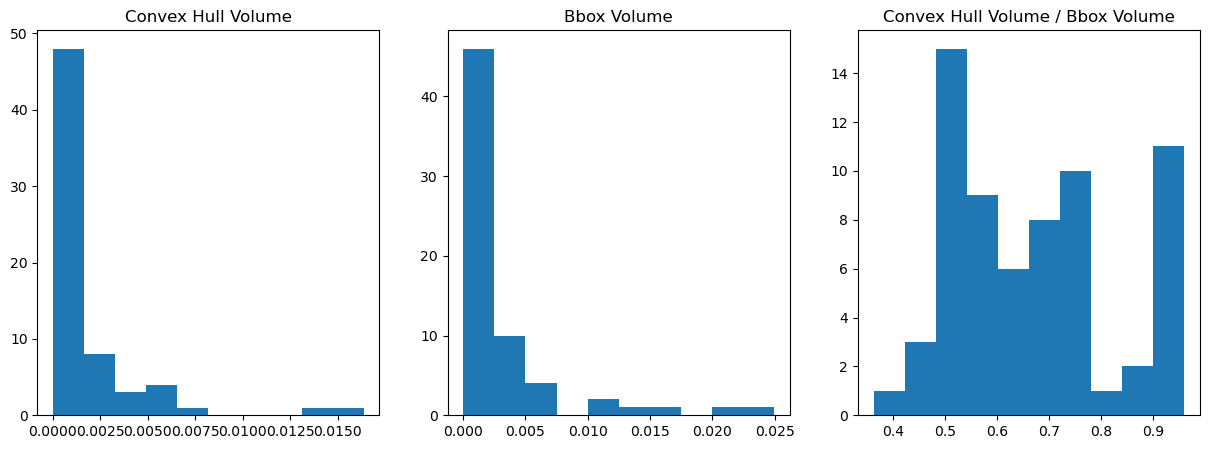

In [8]:
# visualze the distribution of convex hull volume, voxel volume, and their ratio
import matplotlib.pyplot as plt
import numpy as np

convex_hull_volume = [volume_dict[model_id]["convex_hull_volume"] for model_id in volume_dict.keys()]
bbox_volume = [volume_dict[model_id]["bbox_volume"] for model_id in volume_dict.keys()]
ratio = [volume_dict[model_id]["ratio"] for model_id in volume_dict.keys()]

# use subplot to plot three figures in one figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(convex_hull_volume, bins=10)
axs[0].set_title("Convex Hull Volume")
axs[1].hist(bbox_volume, bins=10)
axs[1].set_title("Bbox Volume")
axs[2].hist(ratio, bins=10)
axs[2].set_title("Convex Hull Volume / Bbox Volume")
plt.show()



## Annotate model names 

In [10]:
object_ids = [ file.split(".")[0] for file in
    os.listdir("../../data/google_scanned_object/object_thumbnails")
]
container_ids = [ file.split(".")[0] for file in
    os.listdir("../../data/google_scanned_object/container_thumbnails")
]

model_ids = object_ids + container_ids



In [11]:
# generate json file with model_ids as keys and empty string as values
import json 
# with open("../../data/google_scanned_object/model_name_manual.json", 'w') as f:
#     json.dump({model_id: "" for model_id in model_ids}, f, indent=4)